# EDA

In [1]:
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
# plt.style.use('classic')
warnings.filterwarnings("ignore")

In [2]:
def run_sequence_plot(x, y, title='', xlabel="time", ylabel="series"):
    plt.plot(x, y, 'b-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.show(); 

In [3]:
path = './Data/monthly-beer-production-in-austr.csv'
df = pd.read_csv(path, skipfooter=2)
df.head()

,Month,Monthly beer production in Australia: megalitres. Includes ale and stout. Does not include beverages with alcohol percentage less than 1.15. Jan 1956 ? Aug 1995
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


Three issues in the raw data needs to be fixed: (1) the 2nd column's name is  
lengthy, and (2) the values in the 2nd column is not in numeric format

In [4]:
# Fix problem No. 1
new_columns = df.columns.values
new_columns[1] = "Production"
df.columns = new_columns
df.columns

Index(['Month', 'Production'], dtype='object')

In [5]:
# Fix problem No. 2: convert index of datetimes to a DatetimeIndex for time  
# series operations, like resample.
df.Month = pd.to_datetime(df.Month)
df = df.set_index("Month")
df.tail()

,Production
Month,
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0
1995-07-01,119.0
1995-08-01,153.0


In [6]:
df.index

DatetimeIndex(['1956-01-01', '1956-02-01', '1956-03-01', '1956-04-01',
               '1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
               '1956-09-01', '1956-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Month', length=476, freq=None)

Note that the newly generated index column is of no frequency. We can assign  
it an appropriate one: "MS" which stands for the start of every month.  
For a more general treatment, check this [post](https://stackoverflow.com/questions/31517728/python-pandas-detecting-frequency-of-time-series) for details.

In [7]:
df.index.freq = 'MS'

In [8]:
# Check to see if there is any missing value
all(df.Production.notna()) # answer: True, there is no missing value.

True

In [9]:
# Data splitting for validation
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

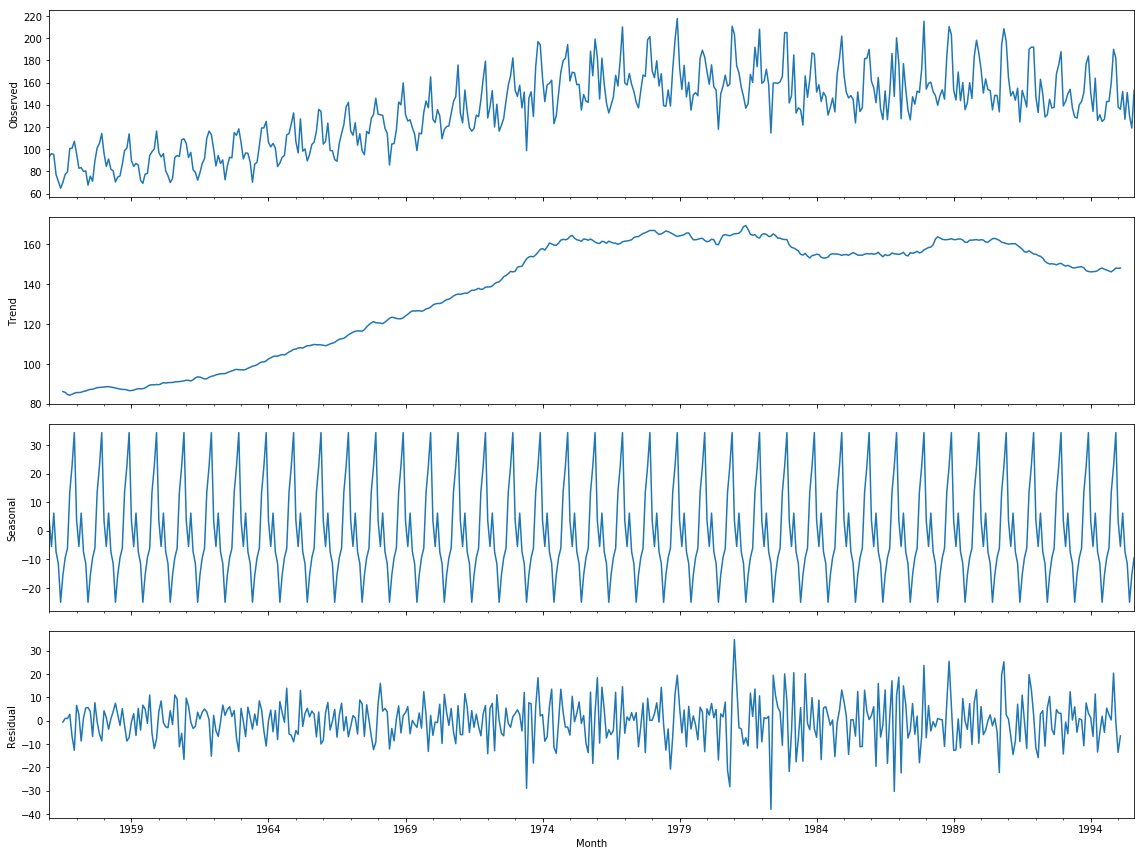

In [10]:
# plt.figure(figsize = (16,12))
plt.rcParams['figure.figsize'] = [16, 12]
a = seasonal_decompose(df["Production"], model = "additive")
a.plot();

# SARIMA Time Series Model

## Automatic Grid Search for the Best Combination

To my experience, this method dramatically reduced the run time in searching  
for the optimal combination given the same parameter space for the algorithm  
to roam on.

In [11]:
# Model Selection.
start_time = time.time()
auto_result = auto_arima(df['Production'], seasonal=True, m=12,max_p=2, max_d=2,max_q=2, max_P=2, max_D=2,max_Q=2)
print('Model fitting took {} seconds'.format(time.time()-start_time))  

Model fitting took 123.95915365219116 seconds


In [12]:
print(auto_result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  476
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1767.742
Date:                            Sat, 30 Nov 2019   AIC                           3553.484
Time:                                    01:06:31   BIC                           3590.953
Sample:                                         0   HQIC                          3568.219
                                            - 476                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.005      0.073      0.942      -0.010       0.010
ar.L1         -0.6681      0.127   

In [13]:
# Out-of-Sample Forecasts
arima_model = SARIMAX(train_data['Production'], order = (2,1,2), seasonal_order = (1,0,2,12))
arima_result = arima_model.fit()
print(arima_result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Production   No. Observations:                  464
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 12)   Log Likelihood               -1723.660
Date:                            Sat, 30 Nov 2019   AIC                           3463.320
Time:                                    01:06:41   BIC                           3496.422
Sample:                                01-01-1956   HQIC                          3476.351
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6831      0.130     -5.256      0.000      -0.938      -0.428
ar.L2         -0.2749      0.039   

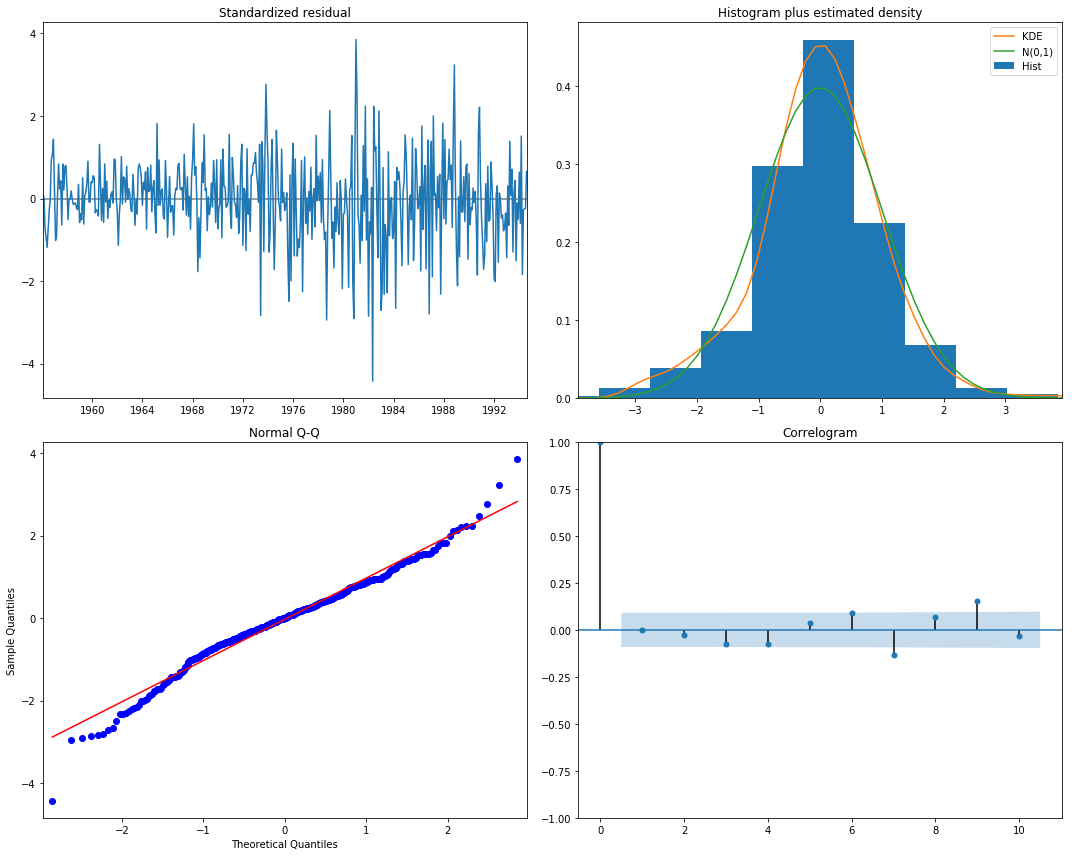

In [14]:
plt.rcParams['figure.figsize'] = [15, 12] 
arima_result.plot_diagnostics()
plt.tight_layout()

The parameter combination, (p,d,q)X(P,D,Q)S, varies across the two methods  
I tested above. I cannot figure out the reason that leads to this divergence  
at the moment. However, the combination obtained from the automatic method  
looks more reasonable to me. Either of the seasonal and non-seasonal degree  
of integration is equal to or smaller than 1, which is a rule mentioned by  
Robert Nau.

In [15]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

1994-09-01    134.616866
1994-10-01    159.208412
1994-11-01    175.515087
1994-12-01    182.710855
1995-01-01    147.202972
1995-02-01    135.296204
1995-03-01    152.363940
1995-04-01    135.321433
1995-05-01    131.899019
1995-06-01    121.141397
1995-07-01    130.440653
1995-08-01    136.345587
Freq: MS, Name: ARIMA Predictions, dtype: float64

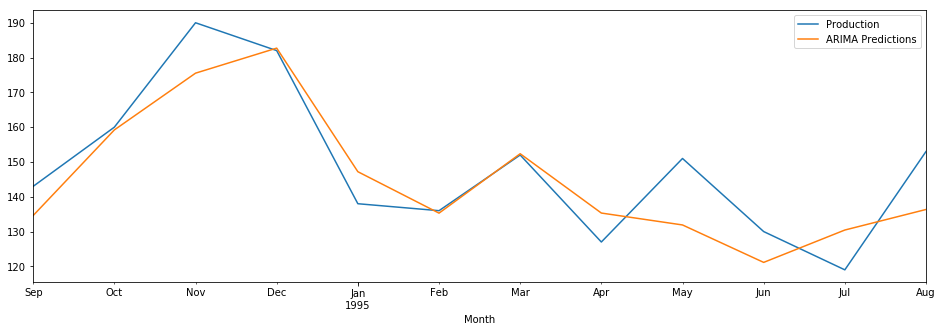

In [16]:
test_data['Production'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [17]:
arima_rmse_error = rmse(test_data['Production'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Production'].mean()

print('MSE Error: {} \nRMSE Error: {} \nMean: {}'.format(arima_mse_error, arima_rmse_error, mean_value))

MSE Error: 107.28088850546261 
RMSE Error: 10.357648792340017 
Mean: 136.3953781512605


In [18]:
test_data['ARIMA_Predictions'] = arima_pred

# LSTM Recurrent Neural Network 

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

Using TensorFlow backend.


In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

print(lstm_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
start_time = time.time()
lstm_model.fit_generator(generator,epochs=25)
print('Model fitting took {} seconds'.format(time.time()-start_time))  


Epoch 1/25
452/452 [==============================] - 8s 17ms/step - loss: 0.0267
Epoch 2/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0154
Epoch 3/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0118
Epoch 4/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0079
Epoch 5/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0081
Epoch 6/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0073
Epoch 7/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0070
Epoch 8/25
452/452 [==============================] - 7s 16ms/step - loss: 0.0078
Epoch 9/25
452/452 [==============================] - 7s 16ms/step - loss: 0.0070
Epoch 10/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0065
Epoch 11/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0066
Epoch 12/25
452/452 [==============================] - 7s 15ms/step - loss: 0.0068
Epoch 13/25


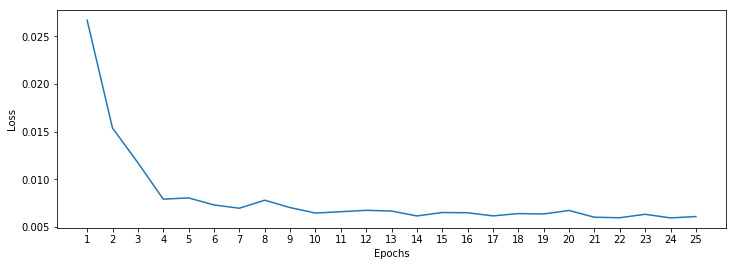

In [23]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,25,1), np.arange(1,26,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [24]:
# ## Out-of-Sample Forecasts with Dynamic Updates

In [25]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [26]:
lstm_predictions_scaled

[array([0.5143844], dtype=float32),
 array([0.59795135], dtype=float32),
 array([0.7101543], dtype=float32),
 array([0.71396434], dtype=float32),
 array([0.54768986], dtype=float32),
 array([0.5178792], dtype=float32),
 array([0.5794052], dtype=float32),
 array([0.43001327], dtype=float32),
 array([0.42876709], dtype=float32),
 array([0.40314704], dtype=float32),
 array([0.4301627], dtype=float32),
 array([0.4889541], dtype=float32)]

In [27]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [28]:
lstm_predictions

array([[143.50081151],
       [156.28655695],
       [173.45360713],
       [174.03654449],
       [148.59654783],
       [144.03551577],
       [153.44899385],
       [130.59203019],
       [130.40136402],
       [126.4814974 ],
       [130.6148928 ],
       [139.60997685]])

In [29]:
test_data['LSTM_Predictions'] = lstm_predictions

In [30]:
test_data

,Production,ARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,134.616866,143.500812
1994-10-01,160.0,159.208412,156.286557
1994-11-01,190.0,175.515087,173.453607
1994-12-01,182.0,182.710855,174.036544
1995-01-01,138.0,147.202972,148.596548
1995-02-01,136.0,135.296204,144.035516
1995-03-01,152.0,152.363940,153.448994
1995-04-01,127.0,135.321433,130.592030
1995-05-01,151.0,131.899019,130.401364


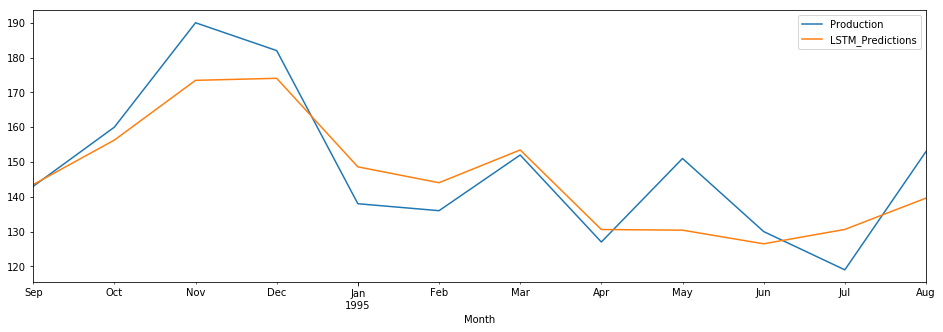

In [31]:
test_data['Production'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [32]:
lstm_rmse_error = rmse(test_data['Production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Production'].mean()

print('MSE Error: {} \nRMSE Error: {} \nMean: {}'.format(lstm_mse_error, lstm_rmse_error, mean_value))

MSE Error: 107.83174463144155 
RMSE Error: 10.384206499845886 
Mean: 136.3953781512605


# Facebook Prophet Additive Model

As quoted from the official webpage of Prophet on GitHub, we know:
> Prophet is a procedure for forecasting time series data based on an additive  
model where non-linear trends are fit with yearly, weekly, and daily  
seasonality, plus holiday effects. It works best with time series that have  
strong seasonal effects and several seasons of historical data. Prophet is  
robust to missing data and shifts in the trend, and typically handles outliers  
well.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Freq: MS
Data columns (total 1 columns):
Production    476 non-null float64
dtypes: float64(1)
memory usage: 7.4 KB


Predictions are then made on a dataframe with a column ds containing the dates  
for which a prediction is to be made. You can get a suitable dataframe that  
extends into the future a specified number of days using the helper method  
Prophet.make_future_dataframe. By default it will also include the dates from  
the history, so we will see the model fit as well.  

Convert series to dataframe with a new column from the original index column:  

In [34]:
df_pr = df.copy()
df_pr = df_pr.reset_index()
df_pr.columns = ['ds','y']

In [35]:
train_data_pr = df_pr[:len(df)-12]
test_data_pr = df_pr[len(df)-12:]

In [36]:
from fbprophet import Prophet

Instantiating a new Prophet object:

In [37]:
m = Prophet()

Calling its `fit` method and pass in the historical dataframe:

In [38]:
m.fit(train_data_pr)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Predictions are made on a dataframe with a column `ds` containing the dates  
for which a prediction is to be made. You can get a suitable dataframe that  
extends into the future a specified number of days using the helper method  
`Prophet.make_future_dataframe`. By default it will also include the dates from  
the history, so we will see the model fit as well.

In [39]:
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [40]:
print(prophet_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds        yhat  yhat_lower  yhat_upper
471 1995-04-01  143.132187  131.000014  155.720767
472 1995-05-01  139.602837  127.375614  151.739086
473 1995-06-01  127.003428  114.386892  139.194836
474 1995-07-01  135.122992  121.549432  147.364838
475 1995-08-01  141.582905  129.041420  153.987160


The predict method will assign each row in future a predicted value which it  
names `yhat`.

In [41]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
test_data["Prophet_Predictions"] = prophet_pred['Pred']

Comparison of forecasts with real data:

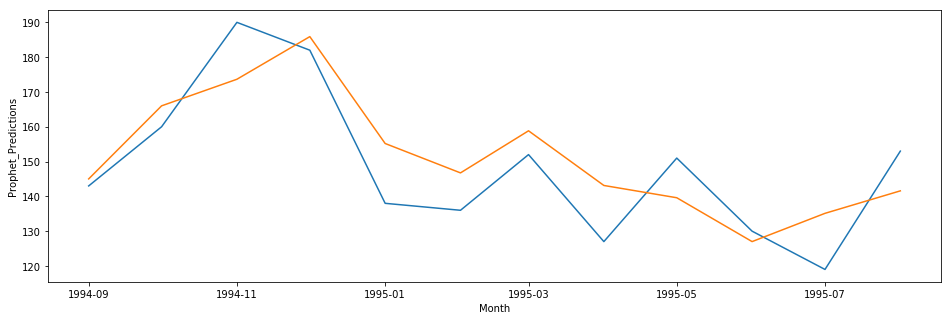

In [42]:
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Production"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [43]:
prophet_rmse_error = rmse(test_data['Production'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Production'].mean()

print('MSE Error: {} \nRMSE Error: {} \nMean: {}'.format(prophet_mse_error, prophet_rmse_error, mean_value))

MSE Error: 130.81766824441812 
RMSE Error: 11.437555169021836 
Mean: 136.3953781512605


Table of Out-of-Sample Forecasting Errors across Models:

In [44]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
print(errors)

   MSE Errors   Models  RMSE Errors
0  107.280889    ARIMA    10.357649
1  107.831745     LSTM    10.384206
2  130.817668  Prophet    11.437555


Plot of Out-of-Sample Forecasts:

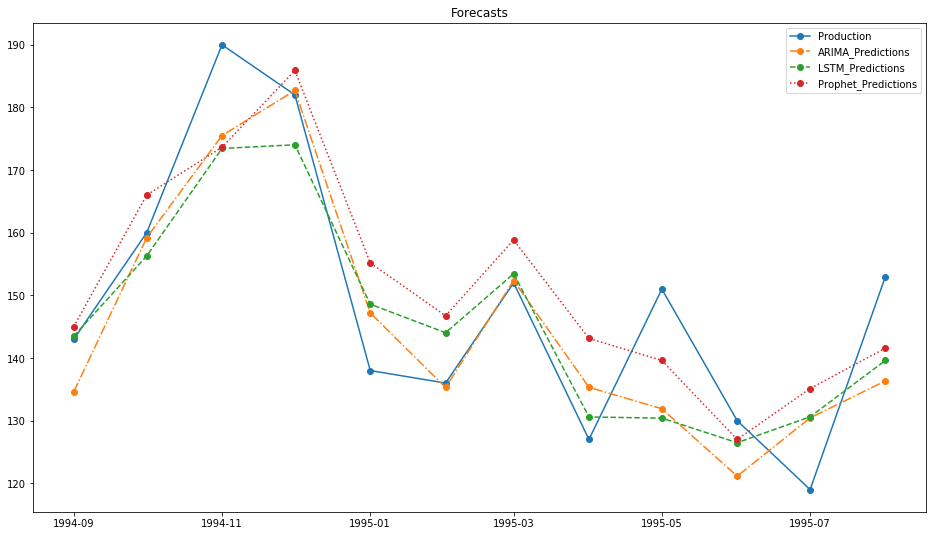

In [45]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Production"], linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.title("Forecasts")
plt.legend() 
plt.show()

# Reference
[1] [Time Series Forecasting — ARIMA, LSTM, Prophet with Python](https://medium.com/@cdabakoglu/time-series-forecasting-arima-lstm-prophet-with-python-e73a750a9887) by Caner Dabakoglu  
[2] [Quick Start | Prophet](https://facebook.github.io/prophet/docs/quick_start.html)  
[3] [Implementing Facebook Prophet efficiently](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) by Ruan van der Merwe  
[4] [Forecasting multiple time-series using Prophet in parallel](https://medium.com/spikelab/forecasting-multiples-time-series-using-prophet-in-parallel-2515abd1a245)  

